In [1]:
import os
import json
import uuid
from workflow_manager import WorkflowManager, MongoWorkflow

In [2]:
# Load the sample input json for the request
example_file = os.path.join(".", "workflow_input_simple_example.txt")
with open(example_file) as f:
    input_json = json.load(f)
#input_json

In [3]:
%%time
# Initialize the workflow class object and inputs
sim_id = str(uuid.uuid4())
debug = False
local = True
workflow = WorkflowManager(
    task_id=sim_id,
    sim_input=input_json["sim_input"],
    order=input_json["network"]["order"],
    sources=input_json["network"]["sources"],
    local=local,
    debug=debug
)
workflow.task_id

Wall time: 5.44 s


'97076d2f-dd94-492b-9dfd-42ac8140dbe3'

In [4]:
workflow.scheduler

LocalCluster(8b905acd, 'tcp://127.0.0.1:51495', workers=4, threads=16, memory=127.76 GiB)

In [5]:
%%time
#TODO: Specify simulation level dependency tasks.
# input_json["simulation_dependencies"] = [{'name': NAME, 'url': URL, 'input': INPUT}]
# These dependencies will correspond to data retrieval tasks, performed by the Workflow manager prior to simulation execution tasks, to the HMS backend
# The results of these dependency tasks are stored in mongoDB by taskID, then passed along in the AQT workflow tasks by id
# The backend will be responsible for the logic and handling of the data
# When the backend merges the data into input (which will need to occur prior to merging the upstream segments) the backend will then save the 
# updated input (for potential reuse)

workflow.define_presim_dependencies(input_json["simulation_dependencies"])

Wall time: 0 ns


In [6]:
%%time
# Construct the dask graph from the catchment list
# Catchment dependencies behave the same way as simulation dependencies, but are only passed to the corresponding segment task and have the appropriate linking.
workflow.construct(input_json["comid_inputs"], input_json["catchment_dependencies"])

Wall time: 320 ms


6177450 : {}
6177476 : {'6177450': '821b7974-cf79-4141-8274-97fe3195edc7'}
6177558 : {'6177476': '1fd4eed5-d809-4b7b-8e3d-978cb97f3bfa'}
Delayed('6177558_4c10965f-92af-439c-998c-372b1520728f')


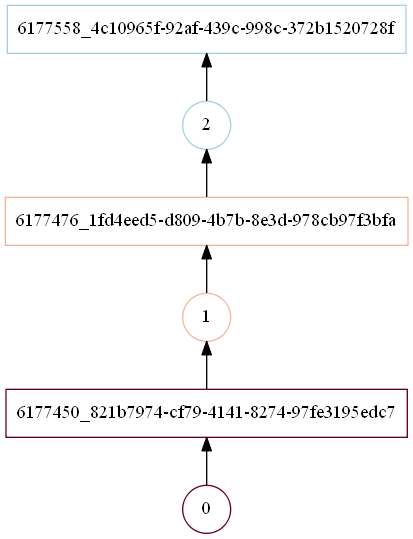

In [7]:
[print(f"{comid} : {c_id}") for comid, c_id in workflow.source_ids.items()]
print(workflow.pourpoint)
workflow.pourpoint.visualize("workflow-graph.png", color='order', verbose=True)

In [8]:
[print(f"{comid} : {c_id}") for comid, c_id in workflow.catchment_ids.items()]

6177450 : 821b7974-cf79-4141-8274-97fe3195edc7
6177476 : 1fd4eed5-d809-4b7b-8e3d-978cb97f3bfa
6177558 : 4c10965f-92af-439c-998c-372b1520728f


[None, None, None]

In [11]:
%%time
# Request to get the simulation status from mongoDB
sim_status = MongoWorkflow.get_status(task_id=sim_id)
# del sim_status["input"]
sim_status

Wall time: 289 ms


{'_id': '97076d2f-dd94-492b-9dfd-42ac8140dbe3',
 'type': 'workflow',
 'status': 'COMPLETED',
 'update_time': '2021-06-17 09:32:48.525385',
 'message': None,
 'catchments': {'6177450': {'status': 'COMPLETED',
   'task_id': '821b7974-cf79-4141-8274-97fe3195edc7',
   'message': None,
   'update_time': '2021-06-17 09:32:19.607305',
   'dependencies': {}},
  '6177476': {'status': 'COMPLETED',
   'task_id': '1fd4eed5-d809-4b7b-8e3d-978cb97f3bfa',
   'message': None,
   'update_time': '2021-06-17 09:32:34.121135',
   'dependencies': {}},
  '6177558': {'status': 'COMPLETED',
   'task_id': '4c10965f-92af-439c-998c-372b1520728f',
   'message': None,
   'update_time': '2021-06-17 09:32:47.932993',
   'dependencies': {}}},
 'network_order': [[6177450], [6177476], [6177558]],
 'catchment_sources': {'6177450': [],
  '6177476': [6177450],
  '6177558': [6177476]},
 'dependencies': {},
 'timestamp': '2021-06-17 14:31:55.675402'}

In [10]:
%%time
# Executes the workflow, based upon the constructed graph
workflow.compute()

Wall time: 43.2 s


In [12]:
%%time
# Get the catchment status from mongoDB
catchment_id = "821b7974-cf79-4141-8274-97fe3195edc7"
catchment_status = MongoWorkflow.get_status(task_id=catchment_id)
# del catchment_status["input"]
catchment_status

Wall time: 114 ms


{'_id': '821b7974-cf79-4141-8274-97fe3195edc7',
 'type': 'catchment',
 'sim_id': '97076d2f-dd94-492b-9dfd-42ac8140dbe3',
 'status': 'COMPLETED',
 'update_time': '2021-06-17 09:32:19.607305',
 'message': None,
 'upstream': {},
 'dependencies': {},
 'runtime': '13.5956',
 'timestamp': '2021-06-17 14:31:55.589584'}

In [13]:
%%time
# Get the catchment data from mongoDB
catchment_data = MongoWorkflow.get_data(task_id=catchment_id)
# del catchment_data["output"]
catchment_data

Wall time: 168 ms


{'_id': '821b7974-cf79-4141-8274-97fe3195edc7',
 'type': 'catchment',
 'sim_id': '97076d2f-dd94-492b-9dfd-42ac8140dbe3',
 'input': {},
 'status': 'COMPLETED',
 'update_time': '2021-06-17 09:32:19.607305',
 'message': None,
 'output': {'$type': 'AQTSim',
  'AQTSeg': {'$type': 'AQUATOXSegment',
   'Location': {'$type': 'TAQTSite',
    'Locale': {'$type': 'SiteRecord',
     'SiteName': {'$type': 'TStringParam',
      'Val': 'LBR Glenwood Br ID',
      'Comment': ''},
     'SiteLength': {'$type': 'TParameter',
      'Val': 0.2099999616,
      'Comment': 'From 2-D Linkage'},
     'Volume': {'$type': 'TParameter', 'Val': 0.0, 'Comment': ''},
     'SurfArea': {'$type': 'TParameter', 'Val': 170000.0, 'Comment': ''},
     'ICZMean': {'$type': 'TParameter', 'Val': 0.82, 'Comment': ''},
     'ZMax': {'$type': 'TParameter', 'Val': 1.82, 'Comment': ''},
     'TempMean': {'$type': 'TParameter', 'Val': 13.0, 'Comment': ''},
     'TempRange': {'$type': 'TParameter', 'Val': 24.0, 'Comment': ''},
     '

In [ ]:
streamflow_dep_id = '0d669e33-d98b-4025-be93-c1eea228f4c7'
streamflow_data = MongoWorkflow.get_data(task_id=streamflow_dep_id)
streamflow_data